# Processus de Prédiction du Modèle d'Apprentissage Automatique sur les performances des pays aux JO
Le modèle d'apprentissage automatique dans ce notebook a suivi un processus méthodique pour arriver à ses prédictions.

1. **Préparation des Données** : 
   - Les données ont été extraites à l'aide d'une requête SQL, sélectionnant des informations pertinentes telles que le pays, la discipline et le nombre de médailles.
   - Des transformations et des nettoyages ont été appliqués, tels que la création de variables cibles indiquant si un pays a gagné des médailles dans plusieurs disciplines.

2. **Division des Données** :
   - Les données ont été divisées en ensembles d'entraînement et de test. Cette étape est importante pour évaluer la performance du modèle de manière impartiale.

3. **Entraînement du Modèle** :
   - Un modèle RandomForestClassifier a été choisi. Ce modèle est connu par sa capacité à traiter des ensembles de données complexes.
   - L'ensemble d'entraînement a été utilisé pour entraîner le modèle, lui permettant d'apprendre les motifs et les relations dans les données.

4. **Prédiction et Évaluation** :
   - Le modèle formé a été utilisé pour faire des prédictions sur l'ensemble de test.
   - Ces prédictions ont été comparées aux valeurs réelles pour évaluer la précision du modèle.

5. **Visualisation des Résultats** :
   - Les prédictions ont été visualisées à l'aide de graphiques, permettant une compréhension intuitive de la performance du modèle.
   - Cette visualisation a aidé à comparer les prédictions du modèle avec les résultats réels, fournissant une évaluation visuelle de son efficacité.

In [363]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Ce bloc de code exécute une requête SQL pour sélectionner le nom du pays, le titre de la discipline et le nombre de médailles. Les données sont regroupées par pays et discipline.

In [364]:
# récupérer les données d'une table spécifique
def retrieve_data(table_name):
    query = f"SELECT * FROM {table_name}"
    data = pd.read_sql(query, engine)
    return data

# Connexion à la base de données MariaDB
db_user = 'jo'
db_password = 'jo'
db_name = 'jo'
db_host = 'localhost'
db_port = '3311'

engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# récupérer les données des différentes tables
table_names = ['athletes', 'results', 'medals']

Prédire les pays médaillés dans au moins 2 disciplines lors des JO de Paris

In [365]:
query = """
SELECT country_name, discipline_title, COUNT(medal_type) as medal_count
FROM medals
GROUP BY country_name, discipline_title
"""
df = pd.read_sql(query, engine)

## Division Entraînement et Test
Cette section du notebook est dédiée à la préparation des données pour le modèle d'apprentissage automatique. Nous effectuons les opérations suivantes :
1. **Division des données** : Les données sont divisées en ensembles d'entraînement et de test (70% entraînement, 30% test), en utilisant une stratification basée sur la variable cible pour assurer une répartition équilibrée.
2. **Séparation des caractéristiques** : Les noms des pays sont conservés dans l'ensemble de test pour une analyse ultérieure, mais retirés de l'ensemble d'entraînement pour éviter le surajustement.


In [366]:
# Compter le nombre de disciplines par pays ayant remporté au moins une médaille
df['medal_disciplines'] = df.groupby('country_name')['discipline_title'].transform('nunique')

# Une variable cible : 1 si un pays a remporté des médailles dans au moins 2 disciplines, 0 sinon
df['target'] = (df['medal_disciplines'] >= 2).astype(int)

# La supression les lignes en double pour le même pays
df.drop_duplicates(subset='country_name', inplace=True)

# Sélectionner les caractéristiques et la cible
X = df[['medal_count', 'medal_disciplines']] 
y = df['target']


## Entraînement du Modèle
Dans cette étape, nous entraînons un modèle de classification pour prédire la performance des pays aux Jeux Olympiques :
1. **Choix du modèle** : Un modèle RandomForestClassifier est sélectionné pour sa capacité à gérer des données catégorielles et numériques et pour sa robustesse face au surajustement.
2. **Entraînement** : Le modèle est entraîné sur l'ensemble d'entraînement pour apprendre à prédire si un pays gagne des médailles dans plusieurs disciplines.
3. **Prédiction** : Après l'entraînement, le modèle est utilisé pour prédire les résultats sur l'ensemble de test.\
    -> 1 : Le pays a une possibilité de gagner.\
    -> 0 : Le pays n'a pas de possibilité de gagner.

In [367]:
# Un DataFrame séparé pour les fonctionnalités, y compris le 'nom du pays'
X_with_country = df[['country_name', 'medal_count', 'medal_disciplines']].copy()

# La division des données, en gardant 'nom du pays' avec les fonctionnalités
X_train, X_test, y_train, y_test = train_test_split(
    X_with_country, 
    y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Séparation des noms des pays et les fonctionnalités pour l'entraînement
country_names_test = X_test['country_name'].values
X_train = X_train.drop(columns=['country_name'])
X_test = X_test.drop(columns=['country_name'])

# Entrainemment du modèle
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Les prédictions
predictions = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate the F1 score
f1 = f1_score(y_test, predictions, average='weighted')  # Use 'weighted' for imbalanced classes
print(f"F1 Score: {f1:.2f}")

# Combiner les noms des pays avec les prédictions
results = pd.DataFrame({
    'country_name': country_names_test, 
    'prediction': predictions
})


Accuracy: 100.00%
F1 Score: 1.00


## Visualisation des Données
Cette dernière partie est consacrée à la visualisation des résultats de la prédiction :
1. **Préparation des données pour la visualisation** : Les prédictions du modèle sont combinées avec les données originales pour créer un ensemble de données complet pour la visualisation.
2. **Création du graphique** : Un graphique combine un diagramme à barres et un nuage de points pour montrer à la fois le nombre réel de disciplines dans lesquelles les pays ont gagné des médailles et les prédictions du modèle.
3. **Interprétation** : Cette visualisation facilite la comparaison entre les performances réelles et prédites, offrant un aperçu intuitif de l'efficacité du modèle.

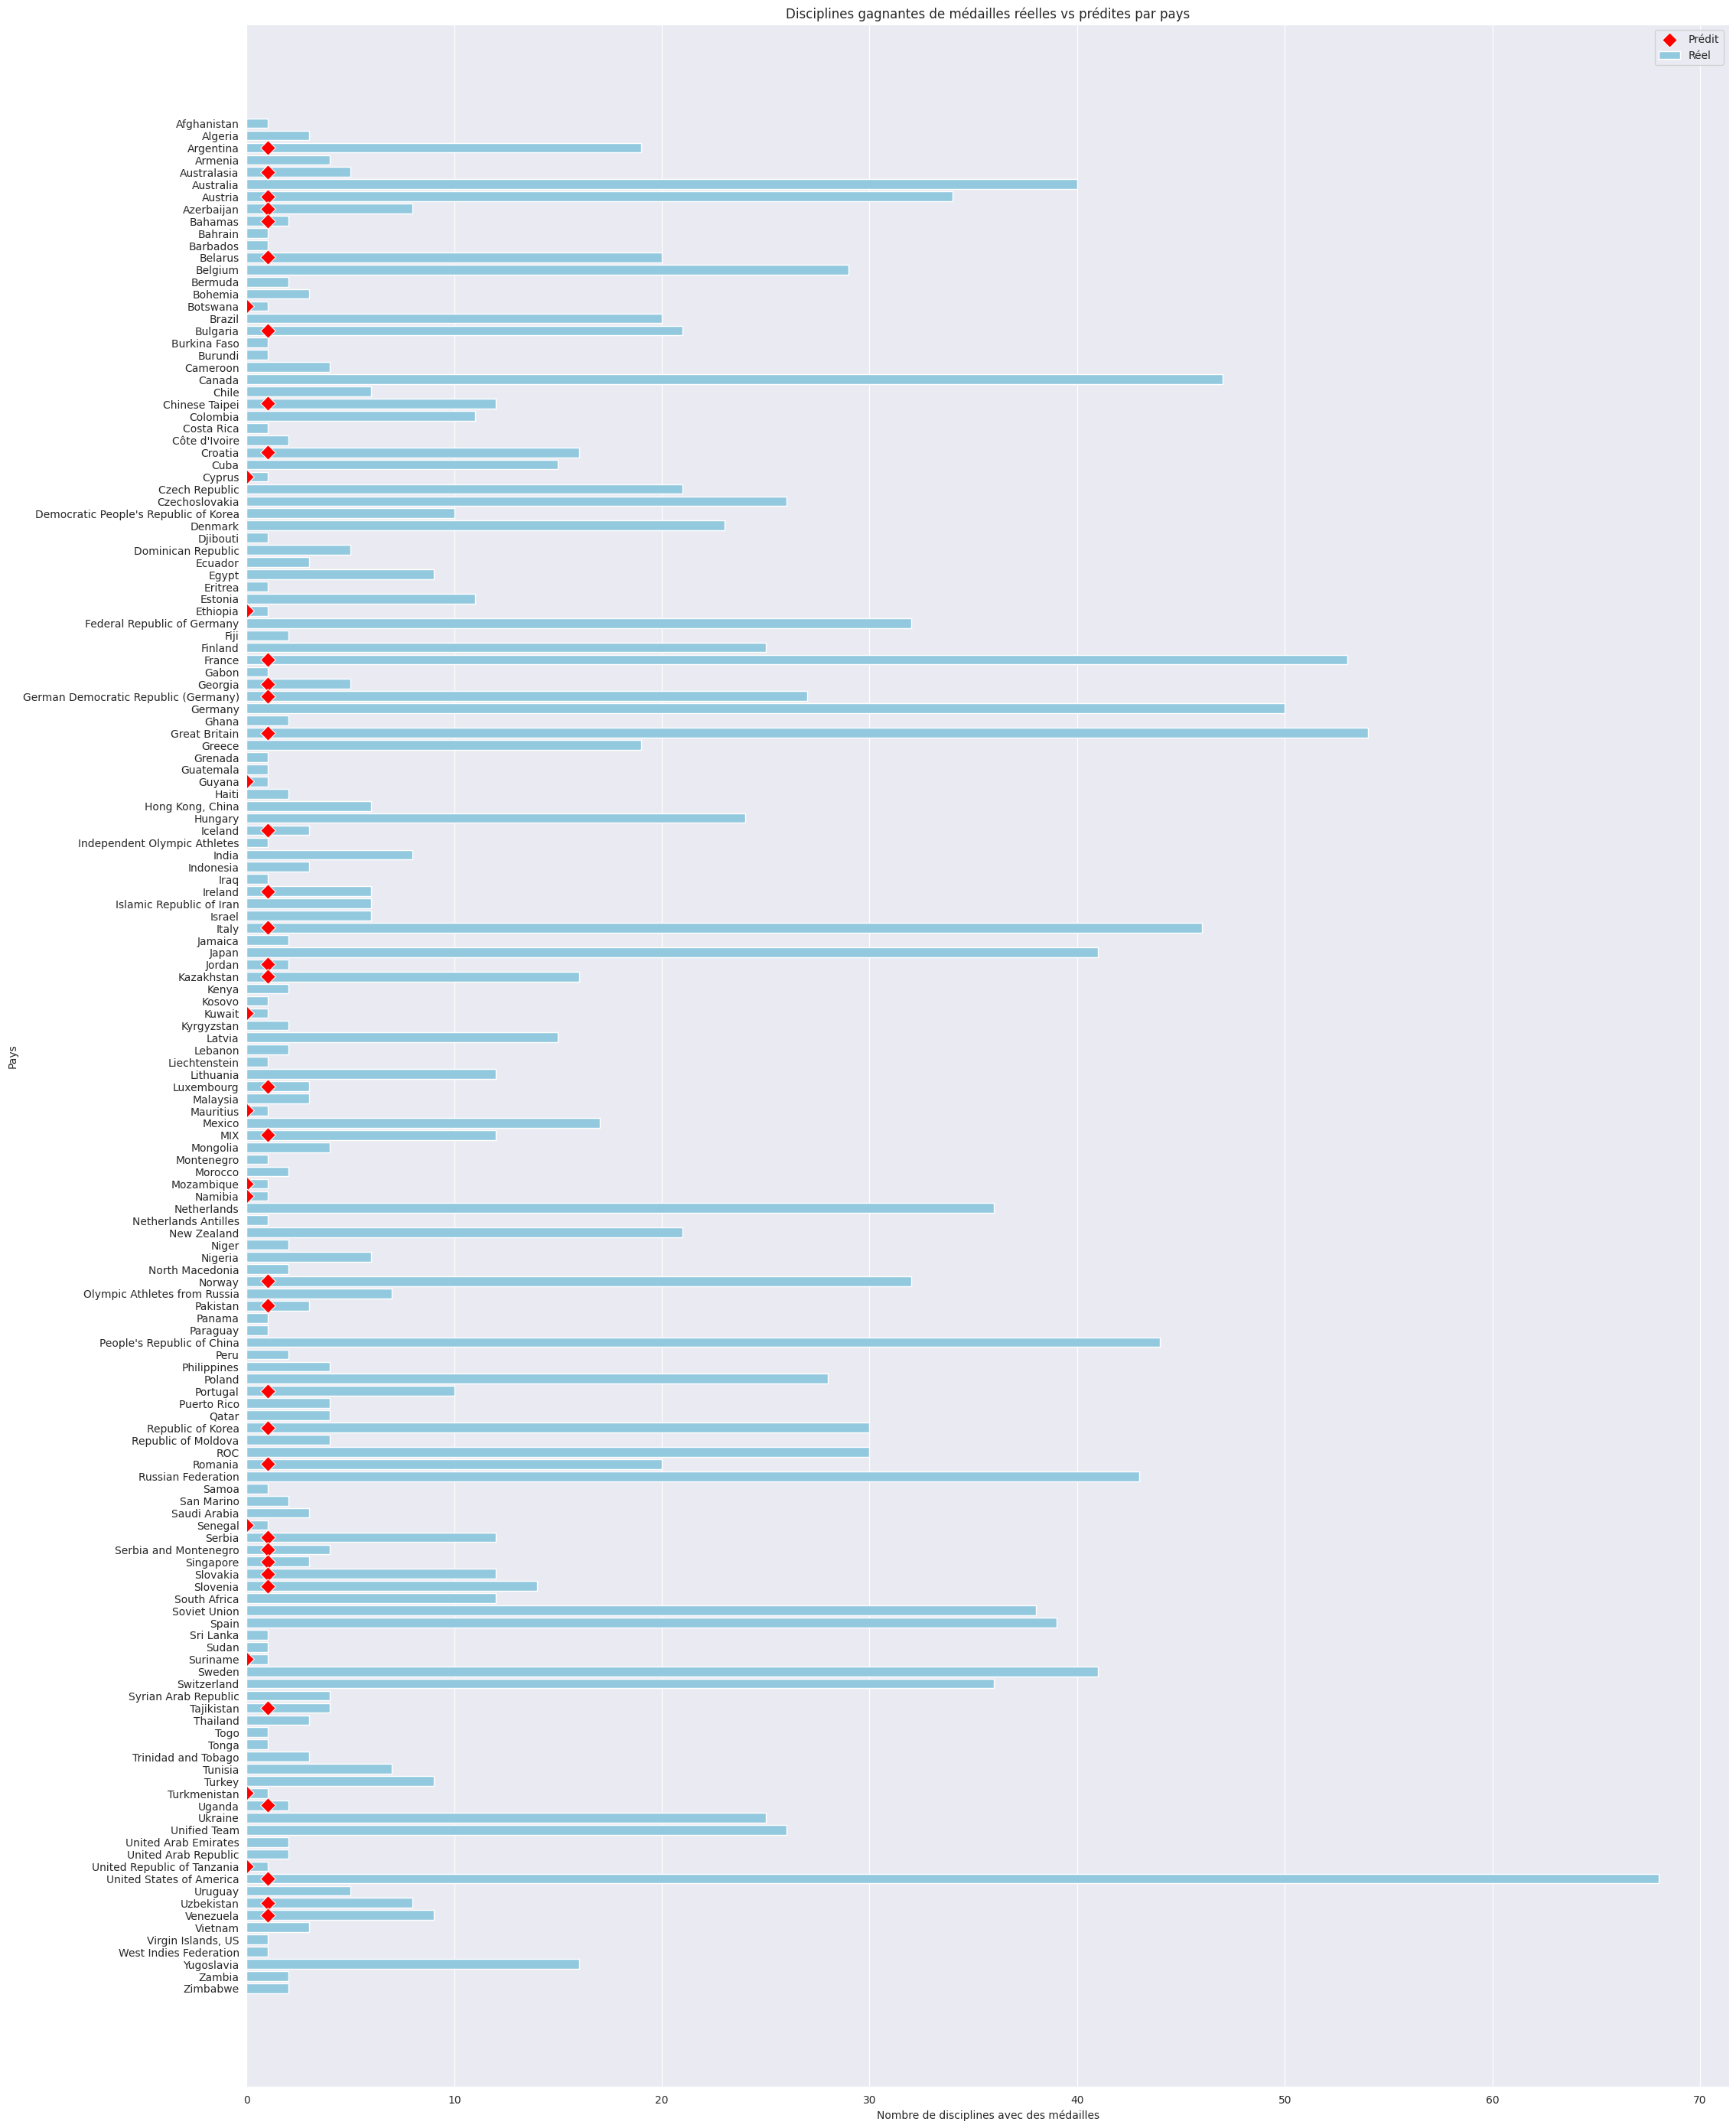

In [368]:
# Création d'un DataFrame à partir du tableau de prédictions
df_predictions = pd.DataFrame({
    'country_name': country_names_test, 
    'prediction': predictions
})

# La fusion des prédictions avec le DataFrame original
df_visualization = df.merge(df_predictions, on='country_name', how='left')


# Filtrer uniquement les colonnes pertinentes pour la visualisation
visualization_data = df_visualization[['country_name', 'medal_disciplines', 'prediction']].drop_duplicates()

# la figure matplotlib
plt.figure(figsize=(25,35))

# Création d'un graphique en barres pour les disciplines réelles avec des médailles
sns.barplot(x='medal_disciplines', y='country_name', data=visualization_data, color='skyblue', label='Réel')

# Un nuage de points pour les pays prévus gagnants de médailles
sns.scatterplot(x='prediction', y='country_name', data=visualization_data, color='red', label='Prédit', marker='D', s=100)

# Les libéllés
plt.xlabel('Nombre de disciplines avec des médailles')
plt.ylabel('Pays')
plt.title('Disciplines gagnantes de médailles réelles vs prédites par pays')
plt.legend()

# Affichez le graphique
plt.show()

## Analyse du Script de Traitement des Données des Athlètes lors des JO PARIS 2024

Cette partie traite les données relatives aux athlètes et à leurs médailles pour prédire leurs performances dans différentes disciplines lors des JO PARIS 2024.

# Prédire les athlètes médaillés dans au moins 2 disciplines lors des JO de Paris ?
## Documentation de cette partie du code :
#### Extraction des données des athlètes
La requête SQL suivante est utilisée pour extraire des données sur les athlètes depuis la base de données `medals`. Cette requête sélectionne le nom de l'athlète, la discipline et le nombre de médailles.

```sql
SELECT athlete_full_name, discipline_title, COUNT(medal_type) as medal_count
FROM medals
WHERE medal_type IS NOT NULL AND athlete_full_name IS NOT NULL
GROUP BY athlete_full_name, discipline_title
```

#### Traitement des données
Après l'extraction des données, nous procédons au traitement des données :
1. ***Compter les disciplines par athlète :*** Nous comptabilisons le nombre unique de disciplines pour lesquelles chaque athlète a remporté au moins une médaille.
2. ***Variable cible :*** Nous créons une variable cible nommée 'target', qui est définie à 1 si un athlète a remporté des médailles dans au moins deux disciplines, sinon à 0.
3. ***Suppression des doublons :*** Nous supprimons les lignes en double pour chaque athlète, assurant l'unicité de chaque athlète dans notre ensemble de données.

#### Sélection des caractéristiques et préparation des données pour l'apprentissage
Avec les données traitées, nous préparons les caractéristiques pour l'apprentissage automatique :
* ***Caractéristiques (Features) :*** Nous sélectionnons 'medal_count' et 'medal_disciplines' comme caractéristiques pour notre modèle.
* ***Cible (Target) :*** La colonne 'target' est utilisée comme variable cible pour la classification.

#### Division des données pour l'entraînement et le test
Nous divisons l'ensemble des données en un ensemble d'entraînement et un ensemble de test en utilisant une répartition de 70/30.

#### Entraînement du modèle
Un modèle de forêt aléatoire `(RandomForestClassifier)` est initialisé avec un état aléatoire fixe pour la reproductibilité. Le modèle est ensuite entraîné avec l'ensemble d'entraînement.

#### Prédiction et évaluation du modèle
Le modèle entraîné fait des prédictions sur l'ensemble de test. Ces prédictions sont ensuite combinées avec les noms complets des athlètes pour l'interprétation.

#### Affichage des résultats
Les prédictions, accompagnées des noms des athlètes, sont affichées pour analyser la performance du modèle. Chaque ligne indique si un athlète est prédit pour gagner des médailles dans au moins deux disciplines lors des JO PARIS 2024.

In [374]:
# Extraire les détails des athlètes depuis la base de données
query_athletes = """
SELECT athlete_full_name, discipline_title, COUNT(medal_type) as medal_count
FROM medals
WHERE medal_type IS NOT NULL AND athlete_full_name IS NOT NULL
GROUP BY athlete_full_name, discipline_title
"""
df_athletes = pd.read_sql(query_athletes, engine)
# Compter le nombre de disciplines par athlète ayant remporté au moins une médaille
df_athletes['medal_disciplines'] = df_athletes.groupby('athlete_full_name')['discipline_title'].transform('nunique')

# Créer une variable cible : 1 si un athlète a des médailles dans au moins 2 disciplines, sinon 0
df_athletes['target'] = (df_athletes['medal_disciplines'] >= 2).astype(int)

# Supprimer les lignes en double pour chaque athlète
df_athletes_unique = df_athletes.drop_duplicates(subset='athlete_full_name')

# Sélectionner les caractéristiques et la cible et conserver le nom de l'athlète comme une colonne
X = df_athletes_unique[['athlete_full_name', 'medal_count', 'medal_disciplines']]
y = df_athletes_unique['target']

# Diviser l'ensemble de données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Conserver les noms des athlètes pour plus tard
athlete_names_train = X_train['athlete_full_name']
athlete_names_test = X_test['athlete_full_name']

# Supprimer la colonne du nom complet de l'athlète pour l'entraînement et la prédiction du modèle
X_train = X_train.drop(columns=['athlete_full_name'])
X_test = X_test.drop(columns=['athlete_full_name'])

# Initialiser le modèle de classification
model = RandomForestClassifier(random_state=42)

# Entraîner le modèle avec l'ensemble d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions avec l'ensemble de test
predictions = model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculer le score F1
f1 = f1_score(y_test, predictions)
print(f"F1 Score: {f1:.2f}")

# Combiner les prédictions avec les noms complets des athlètes
predicted_athletes = pd.DataFrame({
    'AthleteFullName': athlete_names_test,
    'PredictedMedalDisciplines': predictions
}).reset_index(drop=True)

Accuracy: 100.00%
F1 Score: 1.00


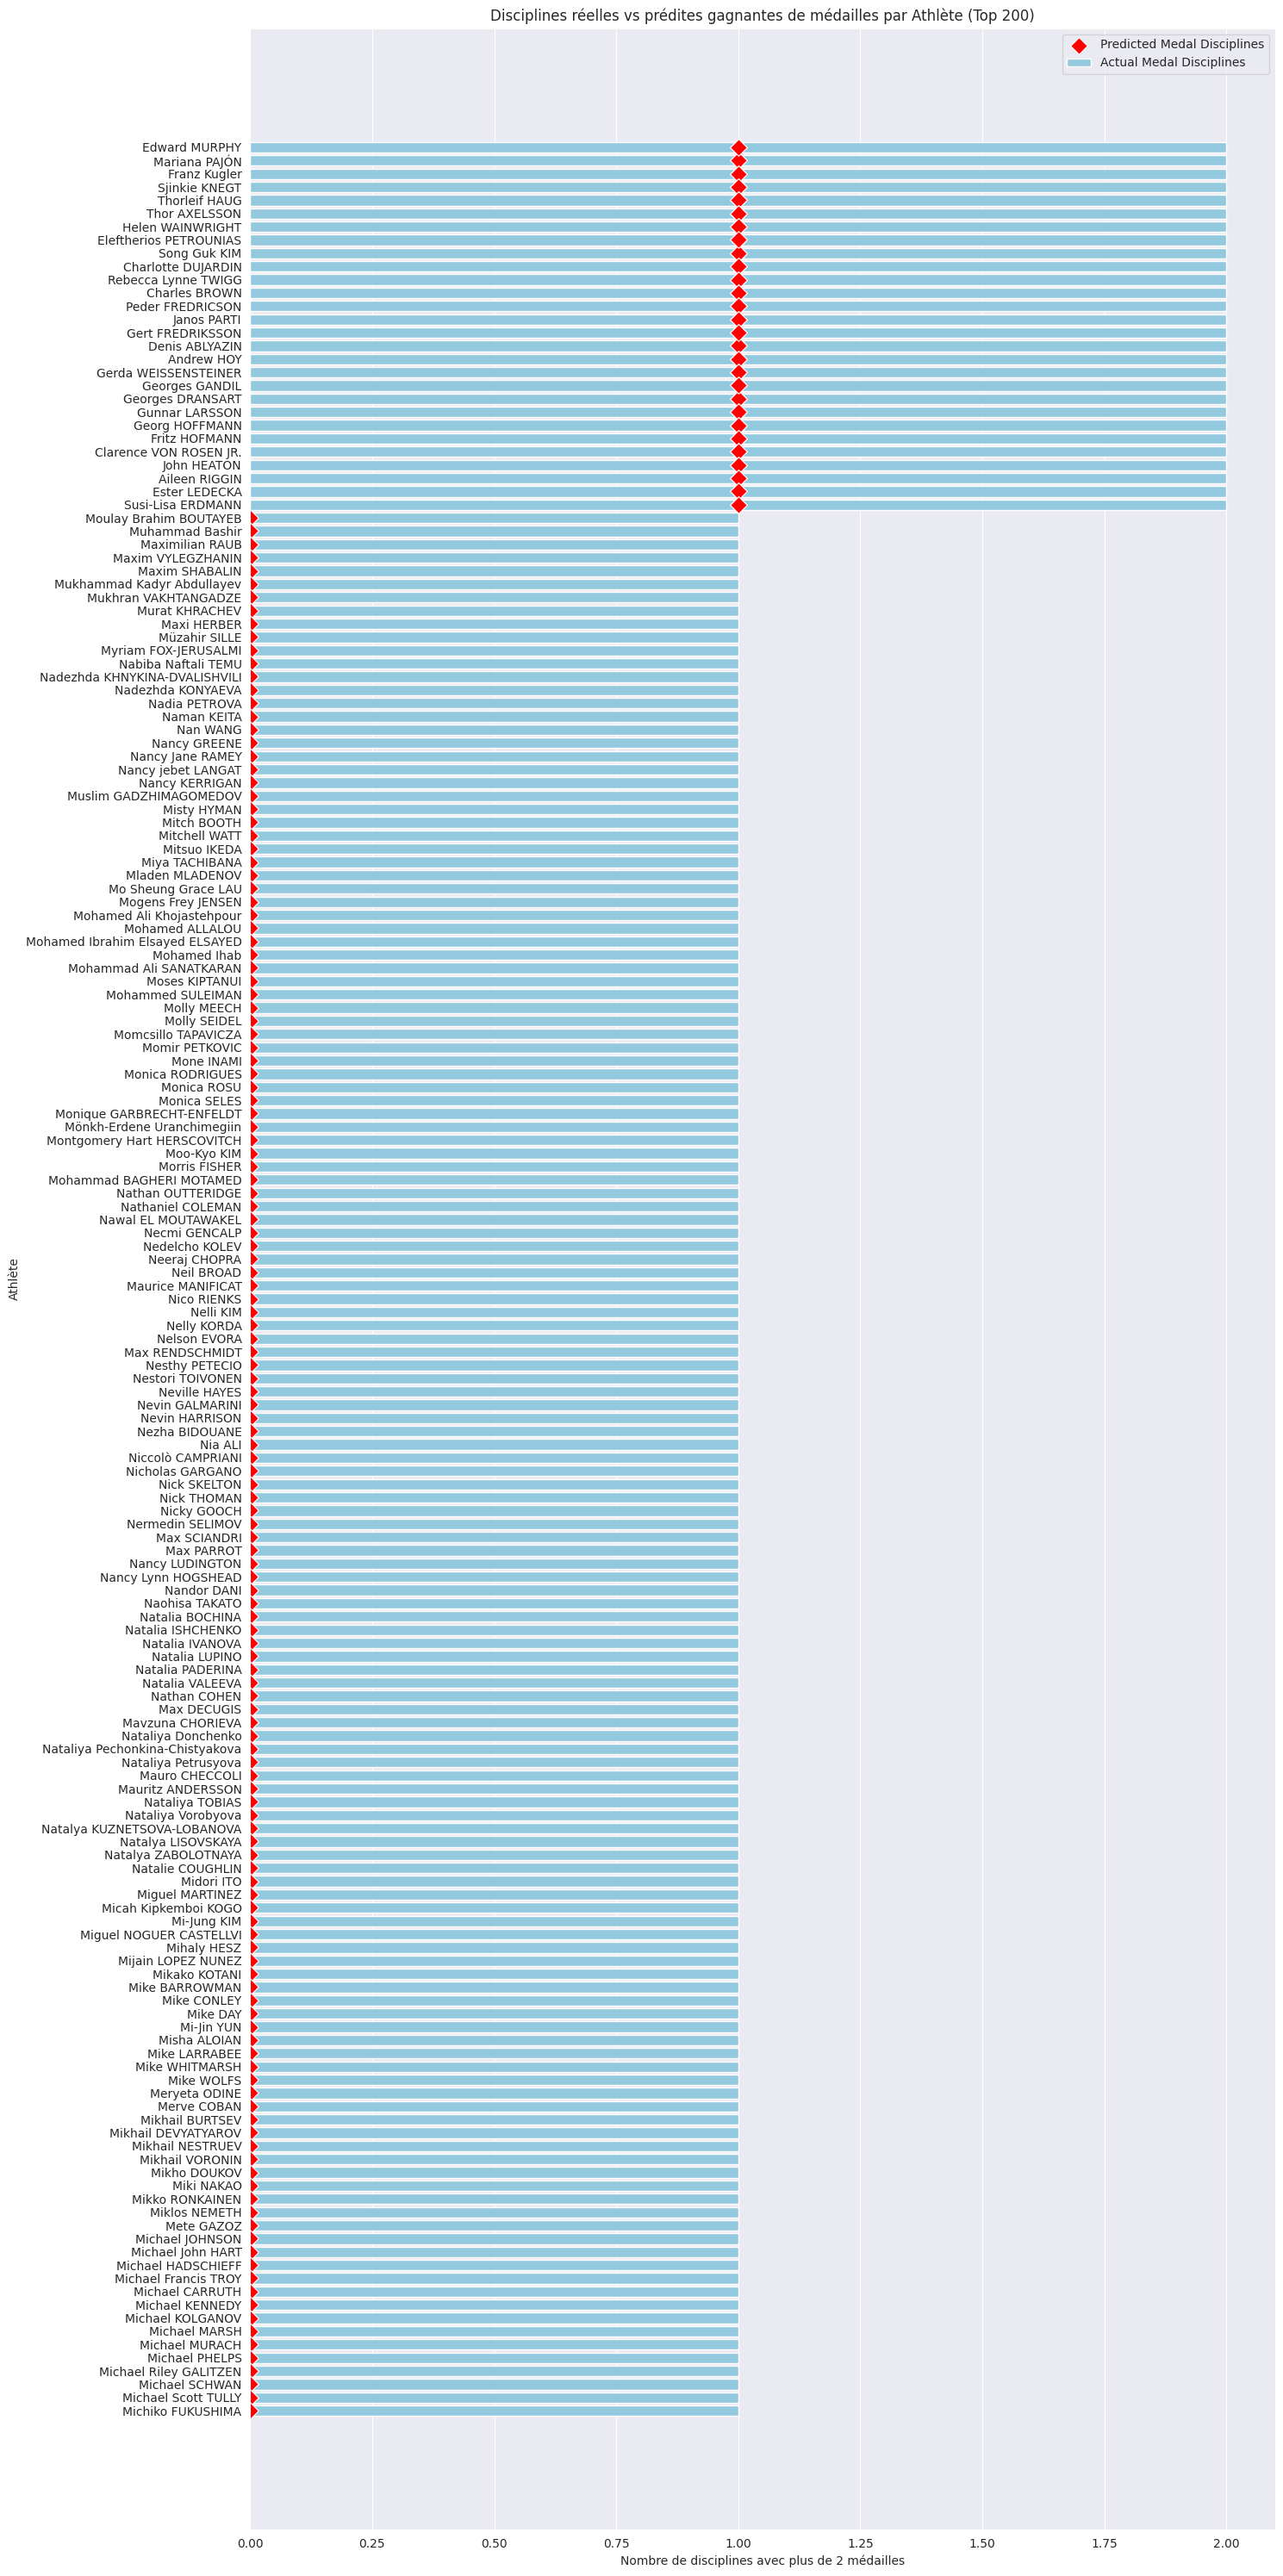

In [375]:
# Fusionner les prédictions avec le DataFrame original pour obtenir les disciplines réelles par le nombre de médailles
visualization_data = df_athletes.merge(
    predicted_athletes, 
    left_on='athlete_full_name', 
    right_on='AthleteFullName', 
    how='inner'
)

# Trier 'visualization_data' par 'medal_disciplines' pour afficher ceux avec le plus de disciplines en premier
visualization_data = visualization_data.sort_values('medal_disciplines', ascending=False)

# Maintenant, réduire le DataFrame pour ne garder que les 200 premières lignes
visualization_data_top200 = visualization_data.head(200)

# Créer la visualisation pour les 200 meilleurs athlètes
plt.figure(figsize=(15, 30))  # Adjust the size as needed for better readability

# Créer un graphique en barres pour le nombre réel de disciplines avec médailles pour les 200 meilleurs athlètes
sns.barplot(
    x='medal_disciplines', 
    y='AthleteFullName', 
    data=visualization_data_top200, 
    color='skyblue', 
    label='Actual Medal Disciplines'
)

# Superposer ceci avec un nuage de points pour les disciplines prévues gagnantes de médailles pour les 200 meilleurs athlètes
sns.scatterplot(
    x='PredictedMedalDisciplines', 
    y='AthleteFullName', 
    data=visualization_data_top200, 
    color='red', 
    label='Predicted Medal Disciplines', 
    s=100, 
    marker='D'  # Diamond shape for better visibility
)

# Ajouter des titres
plt.xlabel('Nombre de disciplines avec plus de 2 médailles')
plt.ylabel('Athlète')
plt.title('Disciplines réelles vs prédites gagnantes de médailles par Athlète (Top 200)')
plt.legend()

# Afficher le graphique
plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

#### Analyse de la prédiction
* la France a historiquement gagné un nombre de médailles proche de cette prédiction lors des précédents Jeux Olympiques, la prédiction pourrait être jugée comme raisonnable.
* Une erreur quadratique moyenne (MSE) d'environ 426,36 est élevée, ce qui indique que peut être les prédictions du modèle sont en moyenne éloignées de la réalité d'environ 20 médailles.

# Prédiction du nombre total de médailles françaises lors des JO de Paris 2024
## Documentation des étapes:
* Chargement des données depuis la base de données.
* Fonction d'extraction de l'année. 
* Application de la fonction et nettoyage des données. 
* Regroupement des données et comptage des médailles. 
* Préparation des données pour le modèle.
* Division des données et entraînement du modèle.
* Évaluation du modèle.
* Prédiction pour les Jeux Olympiques de Paris 2024.


In [376]:
# Question 4 - Pouvez-vous p# Question 4 - Pouvez-vous p# Charger les données depuis la base de données
query = "SELECT * FROM medals WHERE country_name = 'France'" 
data = pd.read_sql(query, engine)

# Fonction pour extraire l'année de la colonne 'slug_game'
def extract_year(slug):
    parts = slug.split('-')
    if len(parts) > 1 and parts[1].isdigit():
        return int(parts[1])
    else:
        return np.nan  # pour représenter des données manquantes ou malformées

# Appliquer la fonction à la colonne 'slug_game'
data['year'] = data['slug_game'].apply(extract_year)

# Supprimer les lignes où 'year' est NaN
data.dropna(subset=['year'], inplace=True)

# Convertir 'year' de float à int
data['year'] = data['year'].astype(int)

# Regrouper les données par année et compter les médailles
medals_per_year = data.groupby('year').size()

# Préparation des données pour le modèle
# Utiliser les années précédentes comme caractéristiques
X = medals_per_year.index.values.reshape(-1, 1)[:-1]  # années
y = medals_per_year.values[:-1]  # nombre de médailles

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sélection et entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Erreur quadratique moyenne : {mse}')

# Prédire pour les Jeux Olympiques de Paris
annee_paris = np.array([[2024]])  
medailles_predites = model.predict(annee_paris)
print(f'Nombre total prévu de médailles françaises aux Jeux Olympiques de Paris : {medailles_predites[0]}')

Erreur quadratique moyenne : 426.363542857143
Nombre total prévu de médailles françaises aux Jeux Olympiques de Paris : 36.67
